# Baseline Model: Logistic Regression

## Imports and Useful Paths

In [1]:
# Helper libraries
import warnings

# Scientific and visual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Various settings
warnings.filterwarnings("ignore")
np.set_printoptions(precision=4)
sns.set_theme()
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_colwidth", 40)
pd.set_option("display.precision", 4)
pd.set_option("display.max_columns", None)

In [2]:
from churn_detection.paths import TRANSFORMED_DATA_DIR

## Loading Datasets

In [3]:
from churn_detection.utils import load_datasets

In [4]:
train_data, val_data, test_data = load_datasets(names=["train", "validation", "test"])

In [5]:
numeric_variables = [
    "tenure", 
    "monthlycharges", 
    "totalcharges"
]

categorical_variables = [
    var for var in train_data.columns
    if var not in numeric_variables
    and var != "churn"
]

## Data Modeling

### Preparation Pipeline

In [6]:
from churn_detection import features

In [7]:
transformers = []
transformers.append(
    features.add_transformation(
        name="continuous", 
        variables=numeric_variables,
        steps=[
            ("dummy_num", features.DummyNumericTransformer()),
        ]
    )
)
transformers.append(
    features.add_transformation(
        name="discrete", 
        variables=categorical_variables,
        steps=[
            ("dummy_cat", features.SimpleCategoryEncoder()),
        ]
    )
)

In [8]:
preprocessor = features.create_column_preprocessor(transformers)

### Final Classifier

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
X_train, y_train = train_data.drop(columns="churn"), train_data.churn
baseline = features.create_pipe(
    preprocessor, LogisticRegression()
)

In [11]:
baseline.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('continuous',
                                                  Pipeline(steps=[('dummy_num',
                                                                   DummyNumericTransformer())]),
                                                  ['tenure', 'monthlycharges',
                                                   'totalcharges']),
                                                 ('discrete',
                                                  Pipeline(steps=[('dummy_cat',
                                                                   SimpleCategoryEncoder())]),
                                                  ['gender', 'seniorcitizen',
                                                   'partner', 'dependents',
                                                   'phoneservice',
                                                   'multiplelines',
                                                   'internetservice',
                                                   'onlinesecurity',
                                                   'onlinebackup',
                                                   'deviceprotection',
                                                   'techsupport', 'streamingtv',
                                                   'streamingmovies',
                                                   'contract',
                                                   'paperlessbilling',
                                                   'paymentmethod'])])),
                ('estimator', LogisticRegression())])

### Model Evaluation

In [12]:
from sklearn.metrics import (classification_report, auc,
                             ConfusionMatrixDisplay,
                             confusion_matrix, 
                             roc_auc_score)

In [13]:
# Train Data
y_train_pred = baseline.predict(X_train)
train_roc_auc = roc_auc_score(y_train_pred, y_train)
print(f"ROC AUC on Train set for standard LR: {train_roc_auc:.2f}")

ROC AUC on Train set for standard LR: 0.75


In [14]:
# Validatio Data
X_val, y_val = val_data.drop(columns="churn"), val_data.churn
y_val_pred = baseline.predict(X_val)
val_roc_auc = roc_auc_score(y_val_pred, y_val)
print(f"ROC AUC on Validation set for standard LR: {val_roc_auc:.2f}")

ROC AUC on Validation set for standard LR: 0.74


In [15]:
from churn_detection.visualization import plot_roc_curve

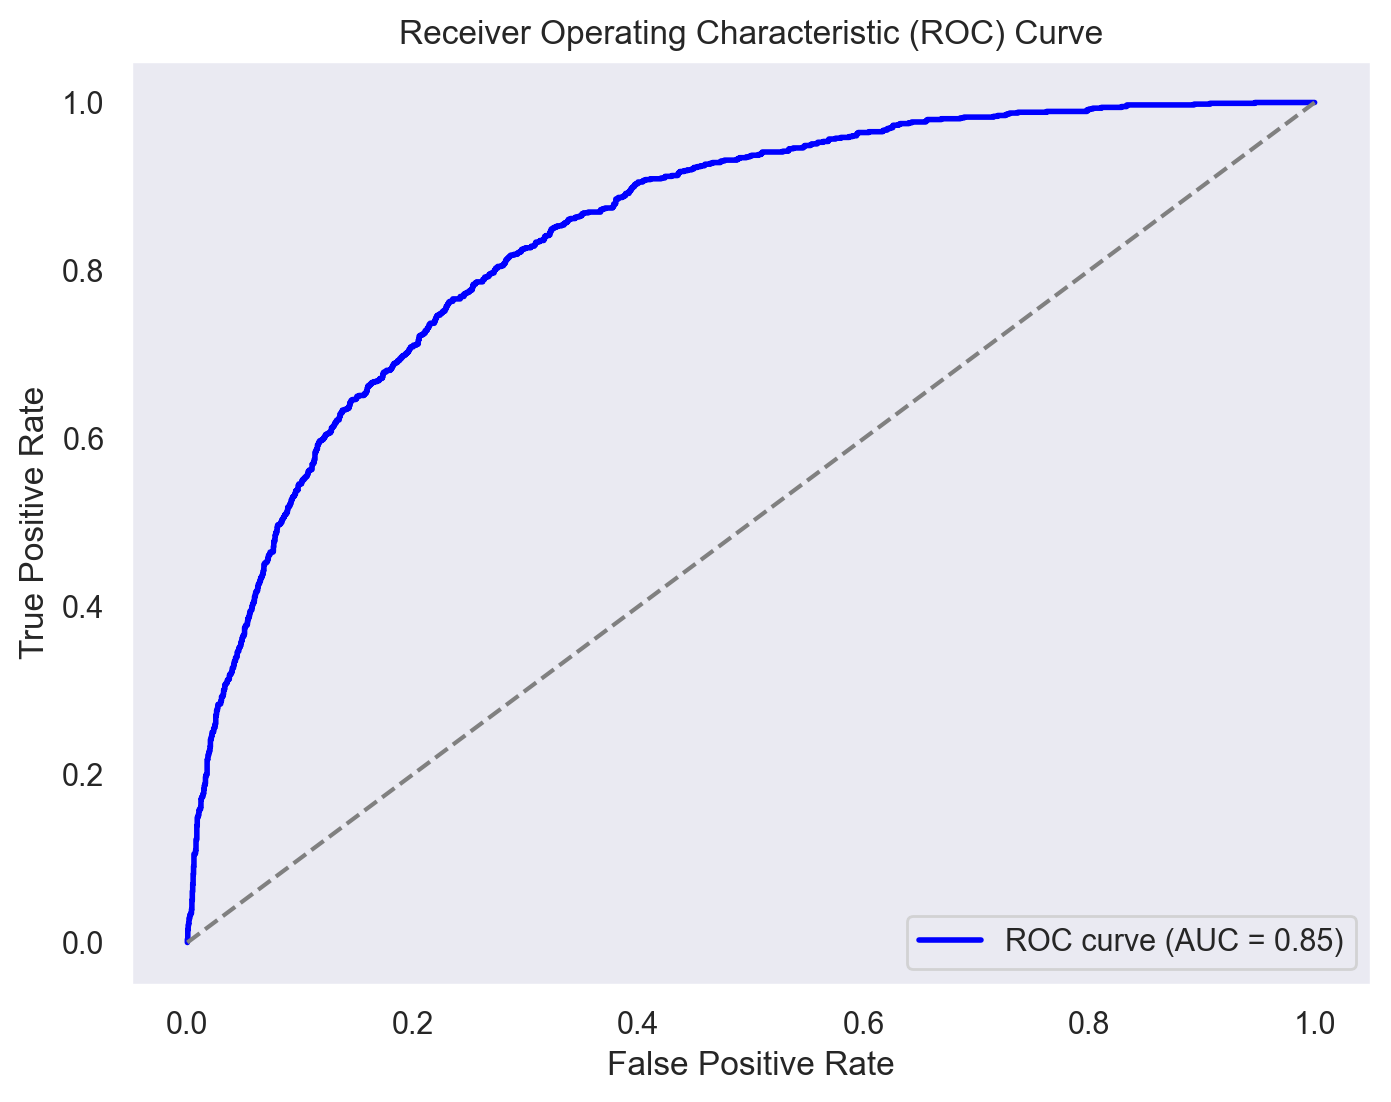

In [16]:
plot_roc_curve(baseline, X_train, y_train)

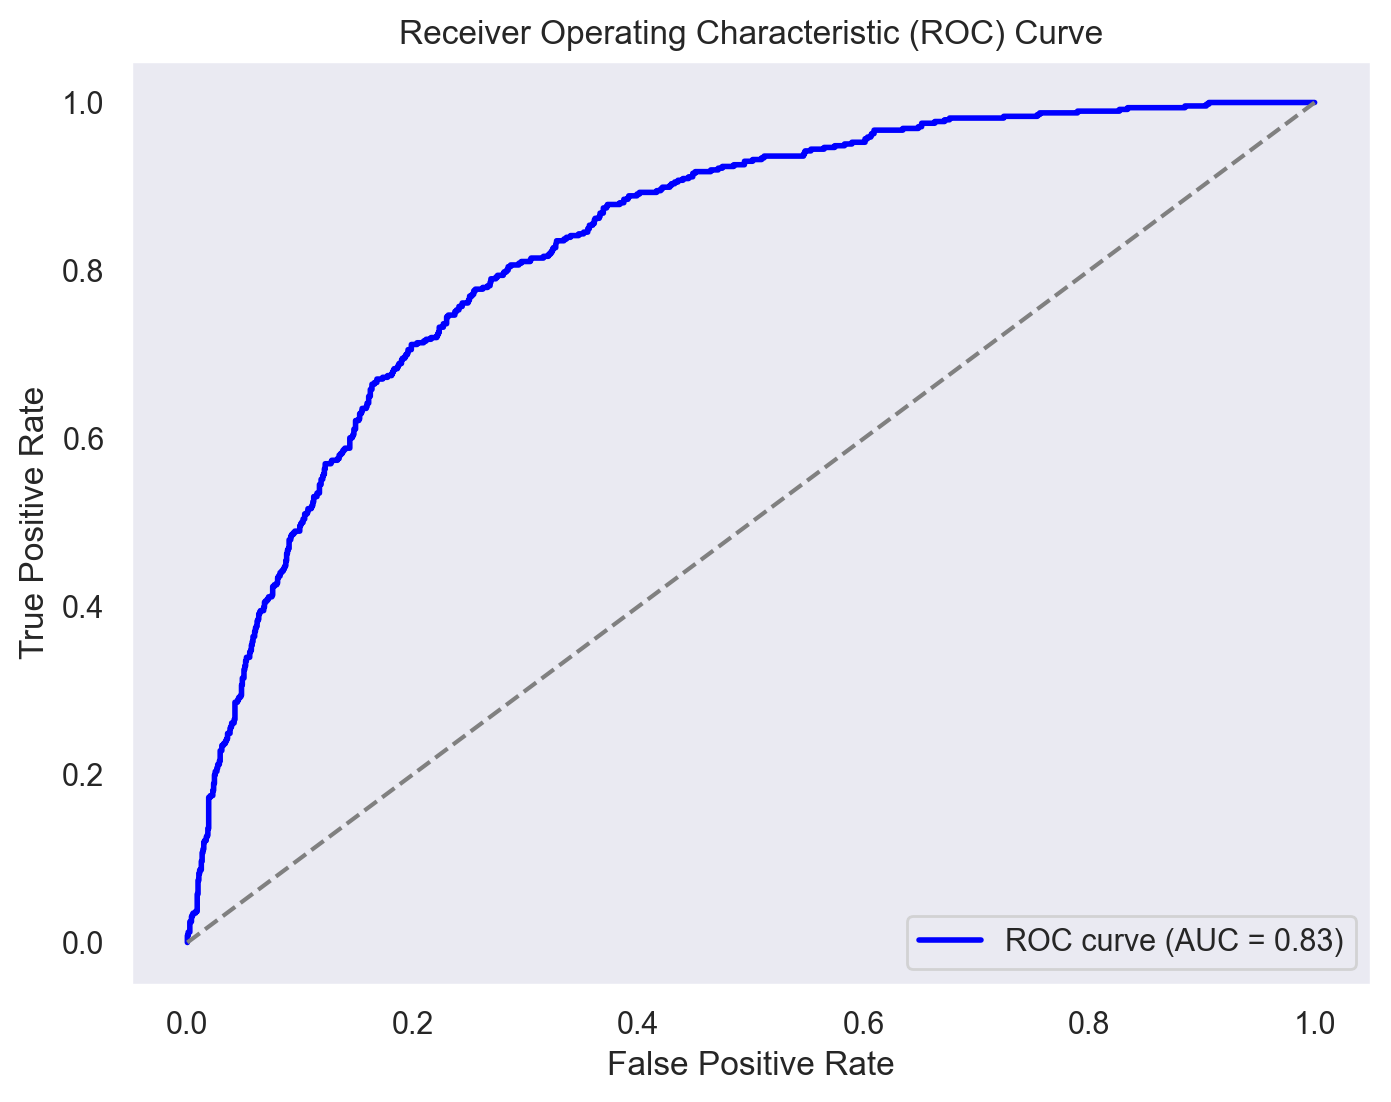

In [17]:
plot_roc_curve(baseline, X_val, y_val)

In [18]:
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

           0       0.89      0.84      0.87      2910
           1       0.55      0.66      0.60       864

    accuracy                           0.80      3774
   macro avg       0.72      0.75      0.74      3774
weighted avg       0.82      0.80      0.81      3774



In [19]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1415
           1       0.57      0.62      0.60       445

    accuracy                           0.80      1860
   macro avg       0.72      0.74      0.73      1860
weighted avg       0.80      0.80      0.80      1860



### Error Inspection

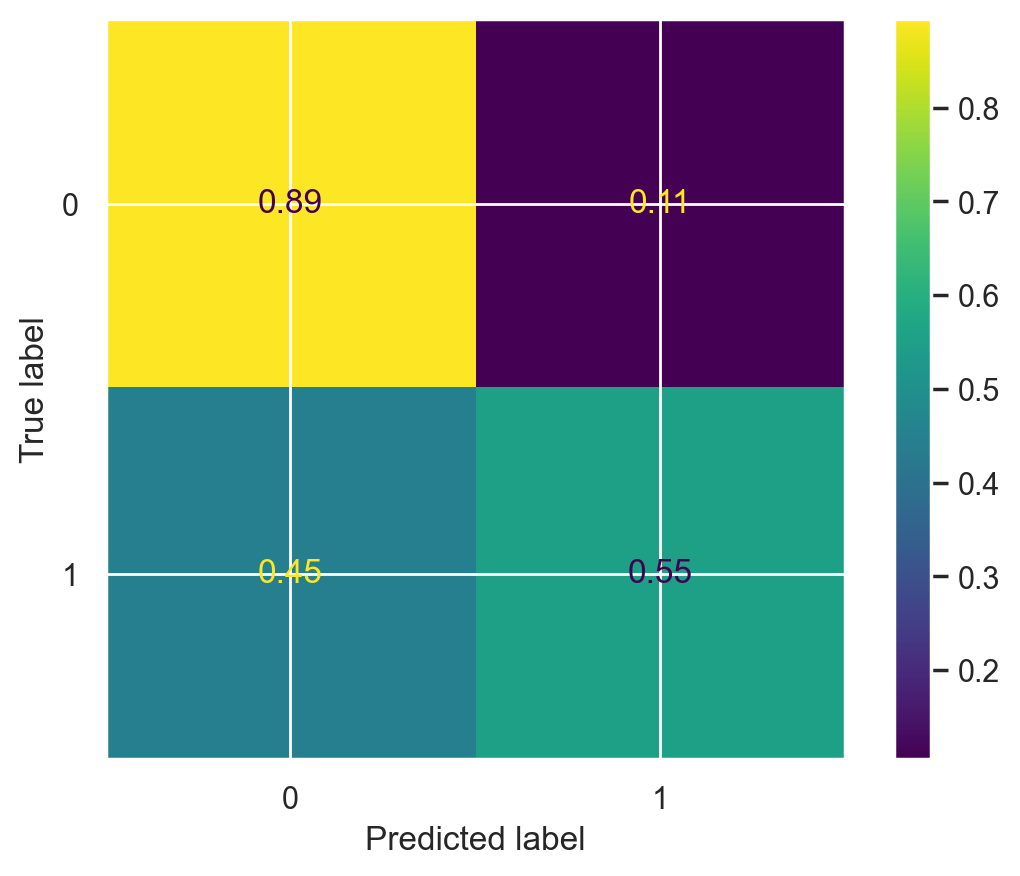

In [20]:
# Train Set
ConfusionMatrixDisplay(
    confusion_matrix(y_train, y_train_pred, normalize="true")
).plot()
plt.show()

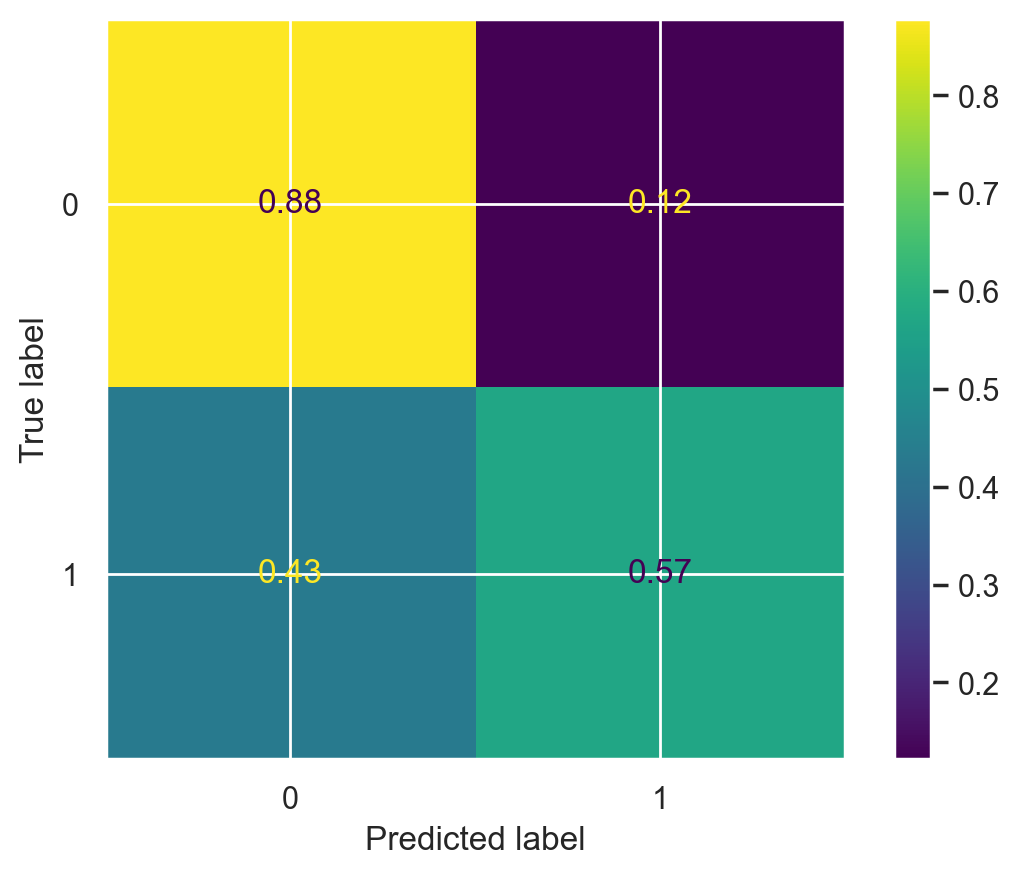

In [21]:
# Validation Set
ConfusionMatrixDisplay(
    confusion_matrix(y_val, y_val_pred, normalize="true")
).plot()
plt.show()

This classifier's ability to predict the positive class as the positive class is weak. It is as good as a random classifier just predicting the non-churn class, but any better model is supposed to beat this performance.